## Insights from analysis

1. Age groups - Older age groups have higher tendency for fraud, especially in males.
2. Job categories - Jobs in legal (officers) have higher tendency for fraud.
3. Time frame - Fraud rate much higher than normal in early parts of both the years
4. Zip code - lesser known zip codes have higher fraud rate
5. Merchants - Merchant fraud_Kozey-Boehm had highest fraud rate
6. Category - shopping_net, misc_net, grocery_pos with highest fraud rate
7. State - DE, RI states with high fraud rates
8. Time & Txn - Fraudulent users tend to max out their credit quicker and make higher value txns

## Next / Additional Steps that could be attempted

1. Spend more time on development of features and feature selection/filtration. For eg: Utilize nlp based techniques to use street, name of user
2. Use additional techniques like ensembling, or downsampling negative (non fraud) class
3. Experiment with unsupervised modelling approaches to find out more undiscovered insights
4. Utilize alternative data sources like email of the user, details of merchant, etc.

In [ ]:
### May need these...
# !pip install scikit-learn
# !pip install category_encoders
# !pip install geopy
# !pip install sklearn-pandas
# !pip install catboost

In [2]:
import calendar
from calendar import day_name
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance
import re
import math
import itertools
palette_color = sns.color_palette('pastel')
from datetime import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import TfidfVectorizer
from category_encoders import MEstimateEncoder

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

pd.set_option('display.max_column', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_seq_items', 100)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None

In [3]:
train_data = pd.read_csv('tr_fincrime_train.csv', index_col=[0])
test_data = pd.read_csv('tr_fincrime_test.csv', index_col=[0])
train_data.shape, test_data.shape

((1296675, 22), (555719, 22))

In [4]:
len(train_data) / (len(train_data) + len(test_data))

0.6999995681264353

In [5]:
train_data.trans_date_trans_time.min(), train_data.trans_date_trans_time.max()

('2019-01-01 00:00:18', '2020-06-21 12:13:37')

In [6]:
test_data.trans_date_trans_time.min(), test_data.trans_date_trans_time.max()

('2020-06-21 12:14:25', '2020-12-31 23:59:34')

In [7]:
train_data.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-null  i

# Data Analysis

In [11]:
cols = ['trans_num', 'unix_time', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'is_fraud',
        'first', 'last', 'dob', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 
        'city_pop', 'job', 'merch_lat', 'merch_long']

train_data = train_data[cols]
test_data = test_data[cols]

In [12]:
train_data.shape

(1296675, 22)

### Transaction Fraud = 0.57% in training dataset and 0.38% in test dataset

In [14]:
train_data.is_fraud.value_counts(normalize=True)

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

In [15]:
test_data.is_fraud.value_counts(normalize=True)

is_fraud
0    0.99614
1    0.00386
Name: proportion, dtype: float64

### User level Fraud = 77.51% in training dataset and 23.59% in test dataset

In [17]:
100 * train_data[train_data.is_fraud == 1].cc_num.nunique() / train_data.cc_num.nunique()

77.51780264496439

In [18]:
100 * test_data[test_data.is_fraud == 1].cc_num.nunique() / test_data.cc_num.nunique()

23.593073593073594

## Feature engineering and analysis

In [19]:
for df in [train_data, test_data]:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['trans_date_trans_weekday'] = df['trans_date_trans_time'].dt.weekday
    df['trans_date_trans_weekday'] = df['trans_date_trans_weekday'].apply(lambda x: calendar.day_name[x])
    df['trans_date_trans_hour'] = df['trans_date_trans_time'].dt.hour
    df['trans_date_trans_month'] = df['trans_date_trans_time'].dt.month
    df['trans_date_trans_year'] = df['trans_date_trans_time'].dt.year
    df['trans_date_trans_month'] = df['trans_date_trans_month'].astype(str)
    df['trans_date_trans_year'] = df['trans_date_trans_year'].astype(str)
    df['trans_date_trans_month_year'] = df['trans_date_trans_month'] + '_' + df['trans_date_trans_year']

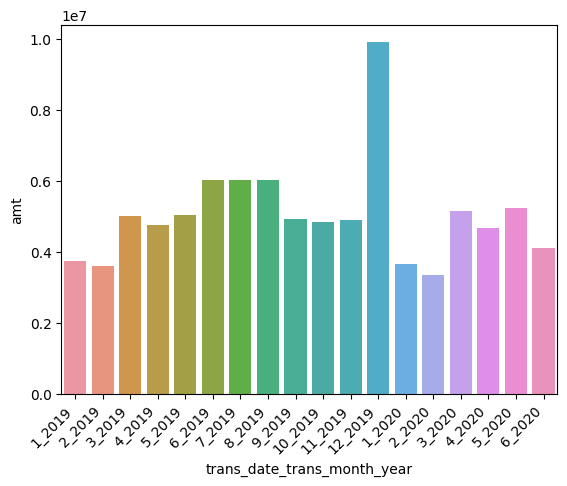

In [20]:
df = train_data.groupby('trans_date_trans_month_year').agg({'trans_num': 'count', 'amt': 'sum'}).reset_index()
df = df.iloc[pd.to_datetime(df['trans_date_trans_month_year'], format='%m_%Y').argsort()]
fig = sns.barplot(data=df, x='trans_date_trans_month_year', y='amt')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right');

In [132]:
train_data['seasonality'] = np.nan
# normal
train_data['seasonality'] = np.where(train_data.trans_date_trans_month_year.isin(['1_2019', '2_2019', '3_2019', '4_2019', '5_2019', '6_2019','7_2019', '8_2019', '9_2019', '10_2019', '11_2019']), 0, train_data['seasonality'])
# christmas?
train_data['seasonality'] = np.where(train_data.trans_date_trans_month_year.isin(['12_2019']), 1, train_data['seasonality'])
# covid
train_data['seasonality'] = np.where(train_data.trans_date_trans_month_year.isin(['1_2020', '2_2020', '3_2020', '4_2020', '5_2020', '6_2020']), 2, train_data['seasonality'])

# covid
test_data['seasonality'] = np.nan
test_data['seasonality'] = np.where(test_data.trans_date_trans_month_year.isin(['12_2020', '11_2020', '10_2020', '9_2020', '8_2020', '7_2020', '6_2020']), 2, test_data['seasonality'])

In [135]:
train_data.seasonality.value_counts(1)

seasonality
0.0    0.604461
2.0    0.286753
1.0    0.108786
Name: proportion, dtype: float64

In [23]:
seasonality_type = train_data.groupby('seasonality').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
seasonality_type['fraud_rate'] = round(100 * (seasonality_type['is_fraud'] / seasonality_type['trans_num']), 4)
seasonality_type.sort_values(['fraud_rate', 'trans_num'], ascending=False).head(5)

,seasonality,is_fraud,trans_num,fraud_rate
2,2.0,2286,371825,0.6148
0,0.0,4628,783790,0.5905
1,1.0,592,141060,0.4197


In [24]:
seasonality_type = train_data.groupby('trans_date_trans_month_year').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
seasonality_type['fraud_rate'] = round(100 * (seasonality_type['is_fraud'] / seasonality_type['trans_num']), 4)
seasonality_type.sort_values(['fraud_rate', 'trans_num'], ascending=False).head(5)

,trans_date_trans_month_year,is_fraud,trans_num,fraud_rate
5,2_2019,517,49866,1.0368
3,1_2019,506,52525,0.9634
12,5_2020,527,74343,0.7089
6,2_2020,336,47791,0.7031
7,3_2019,494,70939,0.6964


In [25]:
for df in [train_data, test_data]:
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = df['trans_date_trans_time'].dt.year.sub(df['dob'].dt.year)

In [26]:
def func(x):
    try:
        street_no = int(x.split()[-1])
        street_type = x.split()[-2]
    except:
        street_type = x.split()[-1]
    return street_type

for df in [train_data, test_data]:
    df['street_type'] = df.street.apply(lambda x: func(x))

train_data['street_type'].value_counts().head()

street_type
Apt.         327791
Suite        305467
Islands       13860
Mission       10858
Mountains     10761
Name: count, dtype: int64

In [27]:
street_type = train_data.groupby('street_type').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
street_type['fraud_rate'] = round(100 * (street_type['is_fraud'] / street_type['trans_num']), 4)
street_type.sort_values(['fraud_rate', 'trans_num'], ascending=False).head()

,street_type,is_fraud,trans_num,fraud_rate
28,Crossing,17,17,100.0
124,Rapid,13,13,100.0
140,Spring,12,12,100.0
27,Crest,11,11,100.0
4,Bridge,9,9,100.0


In [28]:
for df in [train_data, test_data]:
    df['street_type'] = np.where(~df.street_type.isin(['Apt.', 'Suite']), 'Other', df['street_type'])

street_type = train_data.groupby('street_type').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
street_type['fraud_rate'] = round(100 * (street_type['is_fraud'] / street_type['trans_num']), 4)
street_type.sort_values(['fraud_rate', 'trans_num'], ascending=False).head()

,street_type,is_fraud,trans_num,fraud_rate
2,Suite,1792,305467,0.5866
0,Apt.,1917,327791,0.5848
1,Other,3797,663417,0.5723


In [40]:
city_sizes = train_data.drop_duplicates('city')
city_sizes['city_type'] = pd.qcut(city_sizes.city_pop, 5, labels=["village", "town", "large_town", "city", "large_city"])

train_data = train_data.merge(city_sizes[['city', 'city_type']], how='left', on='city')
test_data = test_data.merge(city_sizes[['city', 'city_type']], how='left', on='city')
test_data['city_type'] = np.where(~test_data.city.isin(city_sizes['city'].values), 'city', test_data['city_type'])

pd.qcut(city_sizes.city_pop, 5).unique()

[(1675.8, 4643.0], (22.999, 587.0], (4643.0, 26738.6], (587.0, 1675.8], (26738.6, 2906700.0]]
Categories (5, interval[float64, right]): [(22.999, 587.0] < (587.0, 1675.8] < (1675.8, 4643.0] < (4643.0, 26738.6] < (26738.6, 2906700.0]]

In [41]:
train_data.shape

(1296675, 31)

In [42]:
city_type = train_data.groupby('city_type').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
city_type['fraud_rate'] = round(100 * (city_type['is_fraud'] / city_type['trans_num']), 4)
city_type.sort_values(['fraud_rate', 'trans_num'], ascending=False).head()

,city_type,is_fraud,trans_num,fraud_rate
4,large_city,1756,290065,0.6054
0,village,1614,268701,0.6007
3,city,1337,229365,0.5829
2,large_town,1344,240785,0.5582
1,town,1455,267759,0.5434


In [43]:
zip_counts = train_data.zip.value_counts().reset_index()
zip_counts['zip_counts'] = pd.qcut(zip_counts['count'], 4, labels=['rare', 'low', 'medium', 'high'])
pd.qcut(zip_counts['count'], 4, labels=['rare', 'low', 'medium', 'high'])

0      high
1      high
2      high
3      high
4      high
       ... 
965    rare
966    rare
967    rare
968    rare
969    rare
Name: count, Length: 970, dtype: category
Categories (4, object): ['rare' < 'low' < 'medium' < 'high']

In [44]:
train_data = train_data.merge(zip_counts[['zip', 'zip_counts']], how='left', on='zip')
test_data = test_data.merge(zip_counts[['zip', 'zip_counts']], how='left', on='zip')
test_data['zip_counts'] = np.where(~test_data.zip.isin(zip_counts['zip'].values), 'medium', test_data['zip_counts'])

In [46]:
zip_type = train_data.groupby('zip_counts').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
zip_type['fraud_rate'] = round(100 * (zip_type['is_fraud'] / zip_type['trans_num']), 4)
zip_type.sort_values(['fraud_rate', 'trans_num'], ascending=False).head()

,zip_counts,is_fraud,trans_num,fraud_rate
0,rare,1912,87837,2.1768
1,low,1870,225201,0.8304
2,medium,1788,386757,0.4623
3,high,1936,596880,0.3244


In [47]:
### Merchant Fraud

In [48]:
merchant_fraud = train_data.groupby('merchant').agg({'is_fraud': 'sum', 'trans_num': 'nunique'}).reset_index()
merchant_fraud['fraud_rate'] = round(100 * (merchant_fraud['is_fraud'] / merchant_fraud['trans_num']), 4)
merchant_fraud.sort_values('fraud_rate', ascending=False).head(10)

,merchant,is_fraud,trans_num,fraud_rate
337,fraud_Kozey-Boehm,48,1866,2.5723
245,"fraud_Herman, Treutel and Dickens",33,1300,2.5385
304,fraud_Kerluke-Abshire,41,1838,2.2307
79,fraud_Brown PLC,26,1176,2.2109
200,fraud_Goyette Inc,42,1943,2.1616
616,fraud_Terry-Huel,43,1996,2.1543
282,fraud_Jast Ltd,42,1953,2.1505
555,"fraud_Schmeler, Bashirian and Price",41,1968,2.0833
72,fraud_Boyer-Reichert,38,1908,1.9916
372,"fraud_Langworth, Boehm and Gulgowski",39,1969,1.9807


In [49]:
category_fraud = train_data.groupby('category').agg({'is_fraud': 'sum', 'trans_num': 'nunique'}).reset_index()
category_fraud['fraud_rate'] = round(100 * (category_fraud['is_fraud'] / category_fraud['trans_num']), 4)
category_fraud.sort_values('fraud_rate', ascending=False).head(10)

,category,is_fraud,trans_num,fraud_rate
11,shopping_net,1713,97543,1.7561
8,misc_net,915,63287,1.4458
4,grocery_pos,1743,123638,1.4098
12,shopping_pos,843,116672,0.7225
2,gas_transport,618,131659,0.4694
9,misc_pos,250,79655,0.3139
3,grocery_net,134,45452,0.2948
13,travel,116,40507,0.2864
0,entertainment,233,94014,0.2478
10,personal_care,220,90758,0.2424


In [50]:
gender_fraud = train_data.groupby('gender').agg({'is_fraud': 'sum', 'trans_num': 'nunique'}).reset_index()
gender_fraud['fraud_rate'] = round(100 * (gender_fraud['is_fraud'] / gender_fraud['trans_num']), 4)
gender_fraud.sort_values('fraud_rate', ascending=False).head()

,gender,is_fraud,trans_num,fraud_rate
1,M,3771,586812,0.6426
0,F,3735,709863,0.5262


In [51]:
weekday_fraud = train_data.groupby('trans_date_trans_weekday').agg({'is_fraud': 'sum', 'trans_num': 'nunique'}).reset_index()
weekday_fraud['fraud_rate'] = round(100 * (weekday_fraud['is_fraud'] / weekday_fraud['trans_num']), 4)
weekday_fraud.sort_values('fraud_rate', ascending=False).head(10)

,trans_date_trans_weekday,is_fraud,trans_num,fraud_rate
0,Friday,1079,152272,0.7086
4,Thursday,1008,147285,0.6844
6,Wednesday,859,131073,0.6554
2,Saturday,1227,200957,0.6106
5,Tuesday,935,160227,0.5835
3,Sunday,1216,250579,0.4853
1,Monday,1182,254282,0.4648


In [52]:
state_fraud = train_data.groupby('state').agg({'is_fraud': 'sum', 'trans_num': 'nunique'}).reset_index()
state_fraud['fraud_rate'] = round(100 * (state_fraud['is_fraud'] / state_fraud['trans_num']), 4)
state_fraud.sort_values('fraud_rate', ascending=False).head()

,state,is_fraud,trans_num,fraud_rate
8,DE,9,9,100.0000
39,RI,15,550,2.7273
0,AK,36,2120,1.6981
33,NV,47,5607,0.8382
5,CO,113,13880,0.8141


In [53]:
job_fraud = train_data.groupby('job').agg({'is_fraud': 'sum', 'trans_num': 'nunique'}).reset_index()
job_fraud['fraud_rate'] = round(100 * (job_fraud['is_fraud'] / job_fraud['trans_num']), 4)
job_fraud.sort_values('fraud_rate', ascending=False).head(10)

,job,is_fraud,trans_num,fraud_rate
332,Personnel officer,12,12,100.0
20,Air traffic controller,17,17,100.0
1,"Accountant, chartered",11,11,100.0
421,Ship broker,7,7,100.0
426,Solicitor,11,11,100.0
61,Careers adviser,15,15,100.0
245,Information officer,8,8,100.0
35,Armed forces technical officer,8,8,100.0
243,Industrial buyer,10,10,100.0
227,Homeopath,11,11,100.0


In [54]:
train_data.shape

(1296675, 32)

In [55]:
healthcare_list = []
education_list = []
engineering_list = []
it_list = []
scientist_list = []
designer_list = []
finance_list = []
legal_list = []
media_list = []
nature_list = []
corporate_list = []
executive_list = []
other_list = []

def func(x):
    word = x
    
    if word in ["Veterinary surgeon", "Health promotion specialist", "Psychiatric nurse", "Health visitor", "Homeopath", "General practice doctor", "Health and safety adviser", "Dispensing optician", "Art therapist", "Therapist, drama", "Nutritional therapist", "Art therapist", "Therapist, sports", "Music therapist", "Health service manager", "Therapist, art", "Doctor, hospital", "Mental health nurse", "Optician, dispensing", "Doctor, general practice", "Osteopath", "Chiropodist", "Exercise physiologist", "Learning disability nurse", "Phytotherapist", "Occupational hygienist", "Development worker, international aid", "Warden/ranger", "Radiographer, therapeutic", "Occupational psychologist", "Medical sales representative", "Paramedic", "Podiatrist", "Dance movement psychotherapist", "Psychologist, counselling", "Radiographer, diagnostic", "Therapist, occupational", "Paediatric nurse", "Psychiatrist", "Hospital doctor", "Surgeon", "Medical secretary", "Nurse, children's", "Nurse, mental health", "Physiotherapist", "Forensic psychologist", "Clinical biochemist", "Educational psychologist", "Counsellor", "Psychotherapist", "Psychotherapist, child", "Social worker", "Clinical psychologist", "Counselling psychologist", "Community worker", "Family support worker", "Youth worker", "Child psychotherapist", "Psychologist, forensic", "Psychologist, sport and exercise", "Psychologist, clinical"]:
        healthcare_list.append(x)
        return "healthcare"
    
    elif word in ["Careers adviser", "Community education officer", "Administrator, education", "Music tutor", "Private music teacher", "Education officer, museum", "Press sub", "Production manager", "Camera operator", "Editor, commissioning", "Careers information officer", "Teacher, special educational needs", "Early years teacher", "Librarian, academic", "Secondary school teacher", "Special educational needs teacher", "IT trainer", "Higher education careers adviser", "Teacher, early years/pre", "Teacher, primary school", "Teacher, secondary school", "TEFL teacher", "English as a second language teacher", "Teacher, English as a foreign language", "University Professor", "Associate Professor", "Professor Emeritus", "Further education lecturer", "Lecturer, higher education", "Lecturer, further education"]:
        education_list.append(x)
        return "education"
    
    elif word in ["Contracting civil engineer", "Engineer, site", "Engineer, technical sales", "Engineer, drilling", "Biomedical engineer", "Maintenance engineer", "Engineer, petroleum", "Engineer, control and instrumentation", "Engineer, production", "Drilling engineer", "Engineer, automotive", "Petroleum engineer", "Mining engineer", "Water engineer", "Materials engineer", "Energy engineer", "Naval architect", "Engineer, land", "Engineer, mining", "Engineer, biomedical", "Engineer, electronics", "Engineer, communications", "Engineer, agricultural", "Engineer, civil (contracting)", "Engineer, civil (consulting)", "Engineer, manufacturing", "Engineer, structural", "Engineering geologist", "Electronics engineer", "Mechanical engineer", "Electrical engineer", "Chemical engineer", "Network engineer", "Civil engineer, contracting", "Aeronautical engineer", "Manufacturing engineer", "Civil engineer", "Land/geomatics surveyor", "Building surveyor", "Architect", "Construction manager", "Urban planner", "Structural engineer", "Site engineer", "Building control surveyor", "Quantity surveyor", "Surveyor, minerals", "Surveyor, rural practice", "Surveyor, land/geomatics", "Surveyor, hydrographic", "Industrial buyer", "Manufacturing systems engineer", "Production engineer"]:
        engineering_list.append(x)
        return "engineering"
    
    elif word in ["Editor, film/video", "Information systems manager", "Intelligence analyst", "Product designer", "Accounting technician", "Systems developer", "Systems analyst", "Database administrator", "Programmer, multimedia", "Programmer, applications", "Applications developer", "Web designer", "IT consultant", "Data scientist", "Multimedia programmer", "Software engineer", "Product manager", "Project manager", "Risk analyst"]:
        it_list.append(x)
        return "it"
    
    elif word in ["Scientist, clinical (histocompatibility and immunogenetics)", "Physiological scientist", "Clinical research associate", "Colour technologist", "Telecommunications researcher", "Scientist, research (physical sciences)", "Telecommunications researcher", "Operational researcher", "Neurosurgeon", "Product/process development scientist", "Physicist, medical", "Metallurgist", "Statistician", "Health physicist", "Social researcher", "Toxicologist", "Cytogeneticist", "Science writer", "Immunologist", "Audiological scientist", "Geoscientist", "Pathologist", "Geochemist", "Research scientist (maths)", "Research scientist (medical)", "Research scientist (physical sciences)", "Research scientist (life sciences)", "Scientist, marine", "Scientist, research (medical)", "Scientist, research (maths)", "Scientist, physiological", "Scientist, biomedical", "Scientist, audiological", "Biomedical scientist", "Clinical scientist"]:
        scientist_list.append(x)
        return "scientist"
    
    elif word in ["Furniture designer", "Designer, exhibition/display", "Glass blower/designer", "Designer, industrial/product", "Ceramics designer", "Designer, ceramics/pottery", "Designer, multimedia", "Designer, furniture", "Designer, jewellery", "Fine artist", "Exhibition designer", "Animator", "Illustrator", "Graphic designer", "Fashion designer", "Interior and spatial designer", "Set designer", "Exhibition/display designer", "Industrial/product designer", "Textile designer"]:
        designer_list.append(x)
        return "designer"
    
    elif word in ["Accountant, chartered", "Equities trader", "Investment banker, corporate", "Retail banker", "Pension scheme manager", "Insurance risk surveyor", "Insurance broker", "Tax adviser", "Tax inspector", "Senior tax professional/tax inspector", "Futures trader", "Chartered public finance accountant", "Trading standards officer", "Insurance underwriter", "Pensions consultant", "Comptroller", "Corporate investment banker", "Financial adviser", "Accountant, chartered", "Accountant, chartered certified", "Accountant, chartered public finance", "Economist", "Financial trader", "Investment analyst", "Management consultant", "Market researcher", "Retail buyer", "Sales professional, IT"]:
        finance_list.append(x)
        return "finance"
    
    elif word in ["Race relations officer", "Information officer", "Armed forces technical officer", "Lawyer", "Personnel officer", "Sports development officer", "Waste management officer", "Administrator, local government", "Administrator", "Immigration officer", "Human resources officer", "Police officer", "Equality and diversity officer", "Tourism officer", "Licensed conveyancer", "Trade mark attorney", "Claims inspector/assessor", "Patent attorney", "Solicitor", "Solicitor, Scotland", "Barrister", "Legal secretary", "Chartered legal executive (England and Wales)", "Civil Service administrator", "Civil Service fast streamer", "Diplomat", "Local government officer", "Politician's assistant", "Public affairs consultant", "Barrister's clerk", "Government lawyer", "Regulatory affairs officer"]:
        legal_list.append(x)
        return "legal"
    
    elif word in ["Artist", "Writer", "Dancer", "Museum/gallery exhibitions officer", "Video editor", "Television floor manager", "Producer, radio", "Tourist information centre manager", "Public relations account executive", "Press photographer", "Radio broadcast assistant", "Programme researcher, broadcasting/film/video", "Broadcast presenter", "Journalist, newspaper", "Editor, magazine features", "Media buyer", "Public relations officer", "Advertising account executive", "Advertising account planner", "Copywriter, advertising", "Magazine journalist", "Broadcast journalist", "Film/video editor", "Television/film/video producer", "Radio producer", "Television production assistant"]:
        media_list.append(x)
        return "media"
    
    elif word in ["Forest/woodland manager", "Seismic interpreter", "Commercial horticulturist", "Therapist, horticultural", "Herpetologist", "Horticulturist, commercial", "Fisheries officer", "Operations geologist", "Heritage manager", "Amenity horticulturist", "Tree surgeon", "Wellsite geologist", "Archaeologist", "Herbalist", "Curator", "Geologist", "Nature conservation officer", "Arboriculturist", "Environmental consultant", "Ecologist", "Historic buildings inspector/conservation officer", "Geologist, engineering", "Geologist, wellsite", "Geochemist", "Hydrologist", "Soil scientist", "Environmental scientist", "Hydrogeologist", "Environmental health practitioner", "Agricultural consultant", "Horticultural consultant", "Horticultural therapist"]:
        nature_list.append(x)
        return "nature"
    
    elif word in ["Air traffic controller", "Ship broker", "Warehouse manager", "Barista", "Contractor", "Research officer, trade union", "Research officer, political party", "Airline pilot", "Gaffer", "Bookseller", "Fitness centre manager", "Health service manage", "Call centre manager", "Facilities manager", "Development worker, community", "Pilot, airline", "Lexicographer", "Buyer, industrial", "Town planner", "Exhibitions officer, museum/gallery", "Technical brewer", "Chartered loss adjuster", "Firefighter", "Prison officer", "Clothing/textile technologist", "Musician", "Librarian, public", "Magazine features editor", "Probation officer", "Event organiser", "Leisure centre manager", "Hotel manager", "Restaurant manager, fast food", "Travel agency manager", "Sales manager", "Marketing executive", "Retail merchandiser", "Brand manager", "Sales promotion account executive", "Retail buyer", "Visual merchandiser", "Merchandiser, retail", "Sales executive"]:
        corporate_list.append(x)
        return "corporate"
    
    elif word in ["Chief of Staff", "Chief Financial Officer", "Chief Technology Officer", "Chief Marketing Officer", "Chief Operating Officer", "Chief Strategy Officer", "Chief Executive Officer"]:
        executive_list.append(x)
        return "executive"
    
    elif word in ["Sub", "Make", "Dealer", "Land"]:
        other_list.append(x)
        return "other"
    
    return "other"
train_data['job_industry'] = train_data.job.apply(lambda x: func(x))

In [56]:
test_data['job_industry'] = test_data.job.apply(lambda x: func(x))

In [57]:
train_data.is_fraud.sum() / len(train_data)

0.005788651743883394

In [58]:
job_industry = train_data.groupby('job_industry').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
job_industry['fraud_rate'] = round(100 * (job_industry['is_fraud'] / job_industry['trans_num']), 4)
job_industry.sort_values('fraud_rate', ascending=False)

,job_industry,is_fraud,trans_num,fraud_rate
8,legal,490,64700,0.7573
11,other,1403,187878,0.7468
9,media,495,81224,0.6094
4,executive,130,23081,0.5632
10,nature,466,82977,0.5616
0,corporate,667,120854,0.5519
7,it,263,47745,0.5508
3,engineering,932,172092,0.5416
2,education,479,89310,0.5363
5,finance,490,91774,0.5339


In [59]:
train_data.shape

(1296675, 33)

In [60]:
user_distance_avg = train_data.groupby(['cc_num']).agg({'lat': 'mean', 'long': 'mean'}).reset_index().rename(columns={'lat': 'user_mean_lat', 'long': 'user_mean_long'})

train_data = train_data.merge(user_distance_avg, how='left', on='cc_num')


In [61]:
train_data.shape

(1296675, 35)

In [62]:
user_distance_avg = test_data.groupby(['cc_num']).agg({'lat': 'mean', 'long': 'mean'}).reset_index().rename(columns={'lat': 'user_mean_lat', 'long': 'user_mean_long'})

test_data = test_data.merge(user_distance_avg, how='left', on='cc_num')


In [63]:
test_data.shape

(555719, 35)

In [64]:
train_data['user_merch_distance'] = train_data.apply(lambda x: geopy.distance.geodesic((x.lat, x.long), (x.merch_lat, x.merch_long)).km, axis=1)
train_data['user_mean_delta'] = train_data.apply(lambda x: geopy.distance.geodesic((x.lat, x.long), (x.user_mean_lat, x.user_mean_long)).km, axis=1)


In [65]:
test_data['user_merch_distance'] = test_data.apply(lambda x: geopy.distance.geodesic((x.lat, x.long), (x.merch_lat, x.merch_long)).km, axis=1)
test_data['user_mean_delta'] = test_data.apply(lambda x: geopy.distance.geodesic((x.lat, x.long), (x.user_mean_lat, x.user_mean_long)).km, axis=1)


In [66]:
usermerchant_change_from_last_txn = train_data.groupby(['cc_num', 'merchant']).apply(lambda x: (x['user_merch_distance'] - x['user_merch_distance'].shift(1))).reset_index()
usermerchant_change_from_last_txn = usermerchant_change_from_last_txn.rename(columns={'user_merch_distance':'distance_from_last_txn'})

In [67]:
train_data = train_data.join(usermerchant_change_from_last_txn.sort_values('level_2').set_index('level_2')[['distance_from_last_txn']])
train_data.distance_from_last_txn = train_data.distance_from_last_txn.fillna(0)

In [68]:
usermerchant_change_from_last_txn = test_data.groupby(['cc_num', 'merchant']).apply(lambda x: (x['user_merch_distance'] - x['user_merch_distance'].shift(1))).reset_index()
usermerchant_change_from_last_txn = usermerchant_change_from_last_txn.rename(columns={'user_merch_distance':'distance_from_last_txn'})

In [69]:
test_data = test_data.join(usermerchant_change_from_last_txn.sort_values('level_2').set_index('level_2')[['distance_from_last_txn']])
test_data.distance_from_last_txn = test_data.distance_from_last_txn.fillna(0)

In [70]:
train_data.shape, test_data.shape

((1296675, 38), (555719, 38))

In [71]:
train_data.age.min(), train_data.age.max(), train_data.age.mean(), train_data.age.median()

(14, 96, 46.02929801222357, 44.0)

In [72]:
train_data['age_group'] = ''
train_data['age_group'] = np.where(train_data.age < 18, 'young', train_data['age_group'])
train_data['age_group'] = np.where((train_data.age >= 18) & (train_data.age < 30), 'young_adults', train_data['age_group'])
train_data['age_group'] = np.where((train_data.age >= 30) & (train_data.age < 50), 'adults', train_data['age_group'])
train_data['age_group'] = np.where((train_data.age >= 50) & (train_data.age < 60), 'old_adults', train_data['age_group'])
train_data['age_group'] = np.where((train_data.age >= 60), 'old', train_data['age_group'])

In [73]:
test_data['age_group'] = ''
test_data['age_group'] = np.where(test_data.age < 18, 'young', test_data['age_group'])
test_data['age_group'] = np.where((test_data.age >= 18) & (test_data.age < 30), 'young_adults', test_data['age_group'])
test_data['age_group'] = np.where((test_data.age >= 30) & (test_data.age < 50), 'adults', test_data['age_group'])
test_data['age_group'] = np.where((test_data.age >= 50) & (test_data.age < 60), 'old_adults', test_data['age_group'])
test_data['age_group'] = np.where((test_data.age >= 60), 'old', test_data['age_group'])

In [74]:
age_group = train_data.groupby('age_group').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
age_group['fraud_rate'] = round(100 * (age_group['is_fraud'] / age_group['trans_num']), 4)
age_group.sort_values('fraud_rate', ascending=False)

,age_group,is_fraud,trans_num,fraud_rate
2,old_adults,1425,191313,0.7449
1,old,2036,278677,0.7306
4,young_adults,1302,215049,0.6054
0,adults,2683,598206,0.4485
3,young,60,13430,0.4468


In [75]:
train_data['gender_category'] = train_data['gender'] + '_' + train_data['category']
train_data['age_group_category'] = train_data['age_group'] + '_' + train_data['category']
train_data['gender_age_group'] = train_data['gender'] + '_' + train_data['age_group']

In [76]:
test_data['gender_category'] = test_data['gender'] + '_' + test_data['category']
test_data['age_group_category'] = test_data['age_group'] + '_' + test_data['category']
test_data['gender_age_group'] = test_data['gender'] + '_' + test_data['age_group']

In [77]:
gender_age_group = train_data.groupby('gender_age_group').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
gender_age_group['fraud_rate'] = round(100 * (gender_age_group['is_fraud'] / gender_age_group['trans_num']), 4)
gender_age_group.sort_values('fraud_rate', ascending=False)

,gender_age_group,is_fraud,trans_num,fraud_rate
7,M_old_adults,798,101716,0.7845
6,M_old,953,128127,0.7438
1,F_old,1083,150550,0.7194
2,F_old_adults,627,89597,0.6998
9,M_young_adults,610,98834,0.6172
4,F_young_adults,692,116215,0.5954
5,M_adults,1382,250630,0.5514
3,F_young,32,5925,0.5401
0,F_adults,1301,347576,0.3743
8,M_young,28,7505,0.3731


In [78]:
age_group_category = train_data.groupby('age_group_category').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
age_group_category['fraud_rate'] = round(100 * (age_group_category['is_fraud'] / age_group_category['trans_num']), 4)
age_group_category.sort_values('fraud_rate', ascending=False)

,age_group_category,is_fraud,trans_num,fraud_rate
25,old_adults_shopping_net,339,12990,2.6097
39,old_shopping_net,483,19287,2.5043
60,young_grocery_pos,13,530,2.4528
36,old_misc_net,306,14567,2.1006
22,old_adults_misc_net,200,9608,2.0816
...,...,...,...,...
20,old_adults_home,10,18302,0.0546
19,old_adults_health_fitness,6,13164,0.0456
34,old_home,6,26702,0.0225
56,young_entertainment,0,1230,0.0000


In [79]:
gender_category = train_data.groupby('gender_category').agg({'is_fraud': 'sum', 'trans_num': 'count'}).reset_index()
gender_category['fraud_rate'] = round(100 * (gender_category['is_fraud'] / gender_category['trans_num']), 4)
gender_category.sort_values('fraud_rate', ascending=False)

,gender_category,is_fraud,trans_num,fraud_rate
25,M_shopping_net,1027,42208,2.4332
22,M_misc_net,523,27648,1.8916
18,M_grocery_pos,992,58226,1.7037
11,F_shopping_net,686,55335,1.2397
4,F_grocery_pos,751,65412,1.1481
8,F_misc_net,392,35639,1.0999
26,M_shopping_pos,386,48841,0.7903
12,F_shopping_pos,457,67831,0.6737
16,M_gas_transport,363,58992,0.6153
9,F_misc_pos,165,42378,0.3894


### Time, Frequency, Amt based features

In [80]:
train_data = train_data.sort_values('trans_date_trans_time')
test_data = test_data.sort_values('trans_date_trans_time')

In [81]:
user_txn_times = train_data.groupby('cc_num').apply(lambda x: (x['trans_date_trans_time'] - x['trans_date_trans_time'].shift(1)).dt.seconds).reset_index()
train_data = train_data.join(user_txn_times.sort_values('level_1').set_index('level_1').rename(columns={'trans_date_trans_time': 'time_bw_txn'})[['time_bw_txn']])
train_data.time_bw_txn = train_data.time_bw_txn.fillna(0)

user_txn_times = test_data.groupby('cc_num').apply(lambda x: (x['trans_date_trans_time'] - x['trans_date_trans_time'].shift(1)).dt.seconds).reset_index()
test_data = test_data.join(user_txn_times.sort_values('level_1').set_index('level_1').rename(columns={'trans_date_trans_time': 'time_bw_txn'})[['time_bw_txn']])
test_data.time_bw_txn = test_data.time_bw_txn.fillna(0)

In [82]:
user_txn_times = train_data.groupby(['cc_num', 'city']).apply(lambda x: (x['trans_date_trans_time'] - x['trans_date_trans_time'].shift(1)).dt.seconds).reset_index()
train_data = train_data.join(user_txn_times.sort_values('level_2').set_index('level_2').rename(columns={'trans_date_trans_time': 'time_bw_city_txn'})[['time_bw_city_txn']])
train_data.time_bw_city_txn = train_data.time_bw_city_txn.fillna(0)

user_txn_times = test_data.groupby(['cc_num', 'city']).apply(lambda x: (x['trans_date_trans_time'] - x['trans_date_trans_time'].shift(1)).dt.seconds).reset_index()
test_data = test_data.join(user_txn_times.sort_values('level_2').set_index('level_2').rename(columns={'trans_date_trans_time': 'time_bw_city_txn'})[['time_bw_city_txn']])
test_data.time_bw_city_txn = test_data.time_bw_city_txn.fillna(0)

In [83]:
user_txn_times = train_data.groupby(['cc_num', 'trans_date_trans_weekday']).apply(lambda x: (x['trans_date_trans_time'] - x['trans_date_trans_time'].shift(1)).dt.seconds).reset_index()
train_data = train_data.join(user_txn_times.sort_values('level_2').set_index('level_2').rename(columns={'trans_date_trans_time': 'time_bw_weekday_txn'})[['time_bw_weekday_txn']])
train_data.time_bw_weekday_txn = train_data.time_bw_weekday_txn.fillna(0)

user_txn_times = test_data.groupby(['cc_num', 'trans_date_trans_weekday']).apply(lambda x: (x['trans_date_trans_time'] - x['trans_date_trans_time'].shift(1)).dt.seconds).reset_index()
test_data = test_data.join(user_txn_times.sort_values('level_2').set_index('level_2').rename(columns={'trans_date_trans_time': 'time_bw_weekday_txn'})[['time_bw_weekday_txn']])
test_data.time_bw_weekday_txn = test_data.time_bw_weekday_txn.fillna(0)

In [89]:
user_txn_times = train_data.groupby('cc_num').apply(lambda x: x.time_bw_txn.cumsum()).reset_index()
train_data = train_data.join(user_txn_times.sort_values('level_1').set_index('level_1').rename(columns={'time_bw_txn': 'time_cumsum'})[['time_cumsum']])
train_data.time_cumsum = train_data.time_cumsum.fillna(0)

user_txn_times = test_data.groupby('cc_num').apply(lambda x: x.time_bw_txn.cumsum()).reset_index()
test_data = test_data.join(user_txn_times.sort_values('level_1').set_index('level_1').rename(columns={'time_bw_txn': 'time_cumsum'})[['time_cumsum']])
test_data.time_cumsum = test_data.time_cumsum.fillna(0)

In [90]:
user_txn_times = train_data.groupby(['cc_num', 'merchant']).apply(lambda x: x.time_bw_txn.cumsum()).reset_index()
train_data = train_data.join(user_txn_times.sort_values('level_2').set_index('level_2').rename(columns={'time_bw_txn': 'time_merchant_cumsum'})[['time_merchant_cumsum']])
train_data.time_merchant_cumsum = train_data.time_merchant_cumsum.fillna(0)

user_txn_times = test_data.groupby(['cc_num', 'merchant']).apply(lambda x: x.time_bw_txn.cumsum()).reset_index()
test_data = test_data.join(user_txn_times.sort_values('level_2').set_index('level_2').rename(columns={'time_bw_txn': 'time_merchant_cumsum'})[['time_merchant_cumsum']])
test_data.time_merchant_cumsum = test_data.time_merchant_cumsum.fillna(0)

In [91]:
train_data = train_data.sort_values('trans_date_trans_time')
test_data = test_data.sort_values('trans_date_trans_time')

In [92]:
user_amts = train_data.groupby('cc_num').apply(lambda x: (x['amt'] - x['amt'].shift(1))).reset_index()
train_data = train_data.join(user_amts.sort_values('level_1').set_index('level_1').rename(columns={'amt': 'amt_bw_txn'})[['amt_bw_txn']])
train_data.amt_bw_txn = train_data.amt_bw_txn.fillna(0)

user_amts = test_data.groupby('cc_num').apply(lambda x: (x['amt'] - x['amt'].shift(1))).reset_index()
test_data = test_data.join(user_amts.sort_values('level_1').set_index('level_1').rename(columns={'amt': 'amt_bw_txn'})[['amt_bw_txn']])
test_data.amt_bw_txn = test_data.amt_bw_txn.fillna(0)

In [93]:
user_amts = train_data.groupby(['cc_num', 'city']).apply(lambda x: (x['amt'] - x['amt'].shift(1))).reset_index()
train_data = train_data.join(user_amts.sort_values('level_2').set_index('level_2').rename(columns={'amt': 'amt_bw_city_txn'})[['amt_bw_city_txn']])
train_data.amt_bw_city_txn = train_data.amt_bw_city_txn.fillna(0)

user_amts = test_data.groupby(['cc_num', 'city']).apply(lambda x: (x['amt'] - x['amt'].shift(1))).reset_index()
test_data = test_data.join(user_amts.sort_values('level_2').set_index('level_2').rename(columns={'amt': 'amt_bw_city_txn'})[['amt_bw_city_txn']])
test_data.amt_bw_city_txn = test_data.amt_bw_city_txn.fillna(0)

In [94]:
user_amts = train_data.groupby(['cc_num', 'trans_date_trans_weekday']).apply(lambda x: (x['amt'] - x['amt'].shift(1))).reset_index()
train_data = train_data.join(user_amts.sort_values('level_2').set_index('level_2').rename(columns={'amt': 'amt_bw_weekday_txn'})[['amt_bw_weekday_txn']])
train_data.amt_bw_weekday_txn = train_data.amt_bw_weekday_txn.fillna(0)

user_amts = test_data.groupby(['cc_num', 'trans_date_trans_weekday']).apply(lambda x: (x['amt'] - x['amt'].shift(1))).reset_index()
test_data = test_data.join(user_amts.sort_values('level_2').set_index('level_2').rename(columns={'amt': 'amt_bw_weekday_txn'})[['amt_bw_weekday_txn']])
test_data.amt_bw_weekday_txn = test_data.amt_bw_weekday_txn.fillna(0)

In [95]:
user_amts = train_data.groupby('cc_num').apply(lambda x: x.amt.cumsum()).reset_index()
train_data = train_data.join(user_amts.sort_values('level_1').set_index('level_1').rename(columns={'amt': 'amt_cumsum'})[['amt_cumsum']])
train_data.amt_cumsum = train_data.amt_cumsum.fillna(0)

user_amts = test_data.groupby('cc_num').apply(lambda x: x.amt.cumsum()).reset_index()
test_data = test_data.join(user_amts.sort_values('level_1').set_index('level_1').rename(columns={'amt': 'amt_cumsum'})[['amt_cumsum']])
test_data.amt_cumsum = test_data.amt_cumsum.fillna(0)

In [96]:
user_amts = train_data.groupby(['cc_num', 'merchant']).apply(lambda x: x.amt.cumsum()).reset_index()
train_data = train_data.join(user_amts.sort_values('level_2').set_index('level_2').rename(columns={'amt': 'amt_merchant_cumsum'})[['amt_merchant_cumsum']])
train_data.amt_merchant_cumsum = train_data.amt_merchant_cumsum.fillna(0)

user_amts = test_data.groupby(['cc_num', 'merchant']).apply(lambda x: x.amt.cumsum()).reset_index()
test_data = test_data.join(user_amts.sort_values('level_2').set_index('level_2').rename(columns={'amt': 'amt_merchant_cumsum'})[['amt_merchant_cumsum']])
test_data.amt_merchant_cumsum = test_data.amt_merchant_cumsum.fillna(0)

In [97]:
train_data['spent_amount_per_hour'] = train_data['amt_cumsum'] * (60 * 60) / (train_data['time_cumsum'] + 0.00001)
train_data['spent_amount_per_day'] = train_data['amt_cumsum'] * (60 * 60 * 24) / (train_data['time_cumsum'] + 0.00001)
train_data['spent_amount_per_month'] = train_data['amt_cumsum'] * (60 * 60 * 24 * 30) / (train_data['time_cumsum'] + 0.00001)

test_data['spent_amount_per_hour'] = test_data['amt_cumsum'] * (60 * 60) / (train_data['time_cumsum'] + 0.00001)
test_data['spent_amount_per_day'] = test_data['amt_cumsum'] * (60 * 60 * 24) / (train_data['time_cumsum'] + 0.00001)
test_data['spent_amount_per_month'] = test_data['amt_cumsum'] * (60 * 60 * 24 * 30) / (train_data['time_cumsum'] + 0.00001)

In [98]:
train_data = train_data.sort_values('trans_date_trans_time')
test_data = test_data.sort_values('trans_date_trans_time')

In [99]:
windows = ['1H', '3H', '6H', '12H', '24H']
for w in windows:
    train_data[f'moving_amt_avg_{w}'] = train_data.set_index('trans_date_trans_time')\
                                                        .groupby('cc_num')['amt']\
                                                        .rolling(window=w).mean()\
                                                        .reset_index()['amt']
    test_data[f'moving_amt_avg_{w}'] = test_data.set_index('trans_date_trans_time')\
                                                        .groupby('cc_num')['amt']\
                                                        .rolling(window=w).mean()\
                                                        .reset_index()['amt']

In [100]:
train_data = train_data.sort_values(['trans_date_trans_time', 'cc_num'])
test_data = test_data.sort_values(['trans_date_trans_time', 'cc_num'])

In [101]:
user_txns = train_data.groupby('cc_num')['trans_num'].cumcount()+1
user_txns = user_txns.reset_index()
train_data = train_data.join(user_txns.rename(columns={0: 'txn_cumcount'})[['txn_cumcount']])
train_data['txn_count_per_hour'] = train_data['txn_cumcount'] * (60 * 60) / (train_data['time_cumsum'] + 0.00001)
train_data['txn_count_per_day'] = train_data['txn_cumcount'] * (60 * 60 * 24) / (train_data['time_cumsum'] + 0.00001)
train_data['txn_count_per_month'] = train_data['txn_cumcount'] * (60 * 60 * 24 * 30) / (train_data['time_cumsum'] + 0.00001)

user_txns = test_data.groupby('cc_num')['trans_num'].cumcount()+1
user_txns = user_txns.reset_index()
test_data = test_data.join(user_txns.rename(columns={0: 'txn_cumcount'})[['txn_cumcount']])
test_data['txn_count_per_hour'] = test_data['txn_cumcount'] * (60 * 60) / (test_data['time_cumsum'] + 0.00001)
test_data['txn_count_per_day'] = test_data['txn_cumcount'] * (60 * 60 * 24) / (test_data['time_cumsum'] + 0.00001)
test_data['txn_count_per_month'] = test_data['txn_cumcount'] * (60 * 60 * 24 * 30) / (test_data['time_cumsum'] + 0.00001)

In [102]:
train_data.shape, test_data.shape

((1296675, 64), (555719, 64))

In [103]:
city_txns = train_data.groupby(['cc_num', 'city'])['trans_num'].cumcount()+1
city_txns = city_txns.reset_index()
train_data = train_data.join(city_txns.rename(columns={0: 'cities_txned_in'})[['cities_txned_in']])

city_txns = test_data.groupby(['cc_num', 'city'])['trans_num'].cumcount()+1
city_txns = city_txns.reset_index()
test_data = test_data.join(city_txns.rename(columns={0: 'cities_txned_in'})[['cities_txned_in']])

In [105]:
month_txns = train_data.groupby(['cc_num', 'trans_date_trans_month_year'])['trans_num'].cumcount()+1
month_txns = month_txns.reset_index()
train_data = train_data.join(month_txns.rename(columns={0: 'months_txned_in'})[['months_txned_in']])

month_txns = test_data.groupby(['cc_num', 'trans_date_trans_month_year'])['trans_num'].cumcount()+1
month_txns = month_txns.reset_index()
test_data = test_data.join(month_txns.rename(columns={0: 'months_txned_in'})[['months_txned_in']])

In [104]:
merchant_txns = train_data.groupby(['cc_num', 'merchant'])['trans_num'].cumcount()+1
merchant_txns = merchant_txns.reset_index()
train_data = train_data.join(merchant_txns.rename(columns={0: 'merchants_txned_on'})[['merchants_txned_on']])

merchant_txns = test_data.groupby(['cc_num', 'merchant'])['trans_num'].cumcount()+1
merchant_txns = merchant_txns.reset_index()
test_data = test_data.join(merchant_txns.rename(columns={0: 'merchants_txned_on'})[['merchants_txned_on']])

In [106]:
category_txns = train_data.groupby(['cc_num', 'category'])['trans_num'].cumcount()+1
category_txns = category_txns.reset_index()
train_data = train_data.join(category_txns.rename(columns={0: 'categories_txned_on'})[['categories_txned_on']])

category_txns = test_data.groupby(['cc_num', 'category'])['trans_num'].cumcount()+1
category_txns = category_txns.reset_index()
test_data = test_data.join(category_txns.rename(columns={0: 'categories_txned_on'})[['categories_txned_on']])

In [107]:
train_data.shape, test_data.shape

((1296675, 68), (555719, 68))

### Feature transformation

In [108]:
train_data.amt.min(), train_data.amt.max(), train_data.amt.mean()

(1.0, 28948.9, 70.35103545607033)

<Axes: xlabel='amt', ylabel='Density'>

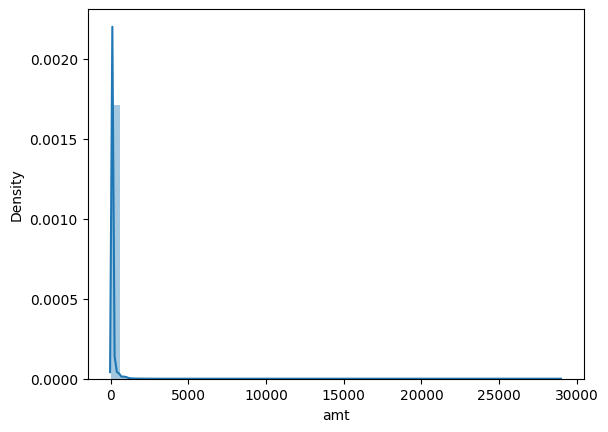

In [109]:
sns.distplot(train_data.amt)

In [110]:
train_data['amt'] = np.log10(train_data['amt'] + 0.00001)
train_data = train_data.drop(columns=['unix_time', 'trans_date_trans_time', 'first', 'last', 'dob'])

test_data['amt'] = np.log10(test_data['amt'] + 0.00001)
test_data = test_data.drop(columns=['unix_time', 'trans_date_trans_time', 'first', 'last', 'dob'])

#### numerical features

In [112]:
numeric_cols = ['amt', 'city_pop', 
               'trans_date_trans_hour', 'trans_date_trans_month',
               'trans_date_trans_year', 'seasonality',
               'age', 
               'user_mean_lat', 'user_mean_long', 'user_merch_distance',
               'user_mean_delta', 'distance_from_last_txn',
               'time_bw_txn', 'time_bw_city_txn', 'time_bw_weekday_txn', 'amt_bw_txn',
               'amt_bw_city_txn', 'amt_bw_weekday_txn', 'amt_cumsum',
               'amt_merchant_cumsum', 'time_cumsum', 'time_merchant_cumsum',
               'spent_amount_per_hour', 'spent_amount_per_day',
               'spent_amount_per_month', 'moving_amt_avg_1H', 'moving_amt_avg_3H',
               'moving_amt_avg_6H', 'moving_amt_avg_12H', 'moving_amt_avg_24H',
               'txn_cumcount', 'txn_count_per_hour', 'txn_count_per_day',
               'txn_count_per_month', 'cities_txned_in', 'months_txned_in', 'merchants_txned_on', 'categories_txned_on']

In [ ]:
def woe_iv(df,X,Y):
    woe_df = pd.DataFrame()
    tempdf = pd.DataFrame()
    
    if 1<(len(df[X].unique()))<10:                           
        TotalY = df.groupby(X)[Y].count()
        SumOf1 = df.groupby(X)[Y].sum()
        SumOf0 = TotalY - SumOf1
        
        tempdf['Min'] = df[X].groupby(df[X]).min()
        tempdf['Max'] = df[X].groupby(df[X]).max()
    
    else:
        binned_x = pd.qcut(df[X],10,duplicates='drop')  
                                                                    
    
        TotalY = df.groupby(binned_x)[Y].count()                  
        SumOf1 = df.groupby(binned_x)[Y].sum()                    
        SumOf0 = TotalY - SumOf1                                  
    
        tempdf['Min'] = df[X].groupby(binned_x).min()            
        tempdf['Max'] = df[X].groupby(binned_x).max()            
    
    tempdf['Count'] = TotalY  
    tempdf['Event'] = SumOf1                                 
    tempdf['NonEvent'] = SumOf0                              
    tempdf.insert(loc=0,column='Variable',value=X)                        
    tempdf['Dist_Event'] = tempdf['Event']/tempdf['Event'].sum()          
    tempdf['Dist_NonEvent'] = tempdf['NonEvent']/tempdf['NonEvent'].sum() 
    tempdf['WOE']= np.log(tempdf.Dist_Event/tempdf.Dist_NonEvent)
    tempdf['IV'] = tempdf['WOE'] * (tempdf['Dist_Event'] - tempdf['Dist_NonEvent'])
    
    print("IV value of " + X + ":" + str(round(tempdf['IV'].sum(),5)))
    ivdf = pd.DataFrame({'Variable': [X], 
                         'IV': [tempdf['IV'].sum()]})
    woe_df = pd.concat([woe_df,tempdf],axis=0)
    
    return woe_df, ivdf

In [115]:
WOE_DF = pd.DataFrame() 
IV_DF  = pd.DataFrame()
count = 0

for feature in numeric_cols:
    train_data[feature] = train_data[feature].astype(float)
    WOE, IV = woe_iv(df=train_data, X=feature,Y='is_fraud')
    if count == 0:
        WOE_DF = pd.concat([WOE,WOE_DF],axis=0)
        IV_DF = pd.concat([IV,IV_DF],axis=0)
        count=count+1
    else:
        WOE_DF = pd.concat([WOE,WOE_DF],axis=0,ignore_index=True)
        IV_DF = pd.concat([IV,IV_DF],axis=0,ignore_index=True)
        count=count+1
IV_DF.sort_values('IV', ascending=False)

IV value of amt:inf
IV value of city_pop:0.00609
IV value of trans_date_trans_hour:1.61578
IV value of trans_date_trans_month:0.05739
IV value of trans_date_trans_year:0.00154
IV value of seasonality:0.01105
IV value of age:0.0635
IV value of user_mean_lat:0.00751
IV value of user_mean_long:0.01139
IV value of user_merch_distance:0.00092
IV value of user_mean_delta:0.0
IV value of distance_from_last_txn:0.09592
IV value of time_bw_txn:0.51401
IV value of time_bw_city_txn:0.51401
IV value of time_bw_weekday_txn:0.48059
IV value of amt_bw_txn:1.35637
IV value of amt_bw_city_txn:1.35637
IV value of amt_bw_weekday_txn:1.30746
IV value of amt_cumsum:0.23587
IV value of amt_merchant_cumsum:1.87533
IV value of time_cumsum:0.21894
IV value of time_merchant_cumsum:0.32614
IV value of spent_amount_per_hour:0.08165
IV value of spent_amount_per_day:0.08165
IV value of spent_amount_per_month:0.08165
IV value of moving_amt_avg_1H:0.00074
IV value of moving_amt_avg_3H:0.00093
IV value of moving_amt_a

,Variable,IV
37,amt,inf
18,amt_merchant_cumsum,1.875333
35,trans_date_trans_hour,1.615778
22,amt_bw_txn,1.356370
21,amt_bw_city_txn,1.356370
20,amt_bw_weekday_txn,1.307461
25,time_bw_txn,0.514014
24,time_bw_city_txn,0.514014
23,time_bw_weekday_txn,0.480586
16,time_merchant_cumsum,0.326139


#### categorical features

In [117]:
cat_cols = ['merchant',
           'category', 'gender',
           'street', 'city', 'state', 'zip', 'job',
           'trans_date_trans_weekday',
           'trans_date_trans_hour', 'trans_date_trans_month',
           'trans_date_trans_month_year',
           'street_type', 'city_type', 'zip_counts', 'job_industry',
           'age_group',
           'gender_category', 'age_group_category', 'gender_age_group']

In [118]:
encoder = MEstimateEncoder(cols=cat_cols, m=5.0)
training_numeric_dataset = encoder.fit_transform(train_data[cat_cols], train_data['is_fraud'])

In [119]:
test_numeric_dataet = encoder.transform(test_data[cat_cols], test_data['is_fraud'])

In [120]:
train_df = train_data.drop(columns=cat_cols).join(training_numeric_dataset)
test_df = test_data.drop(columns=cat_cols).join(test_numeric_dataet)

### Plotting Distributions

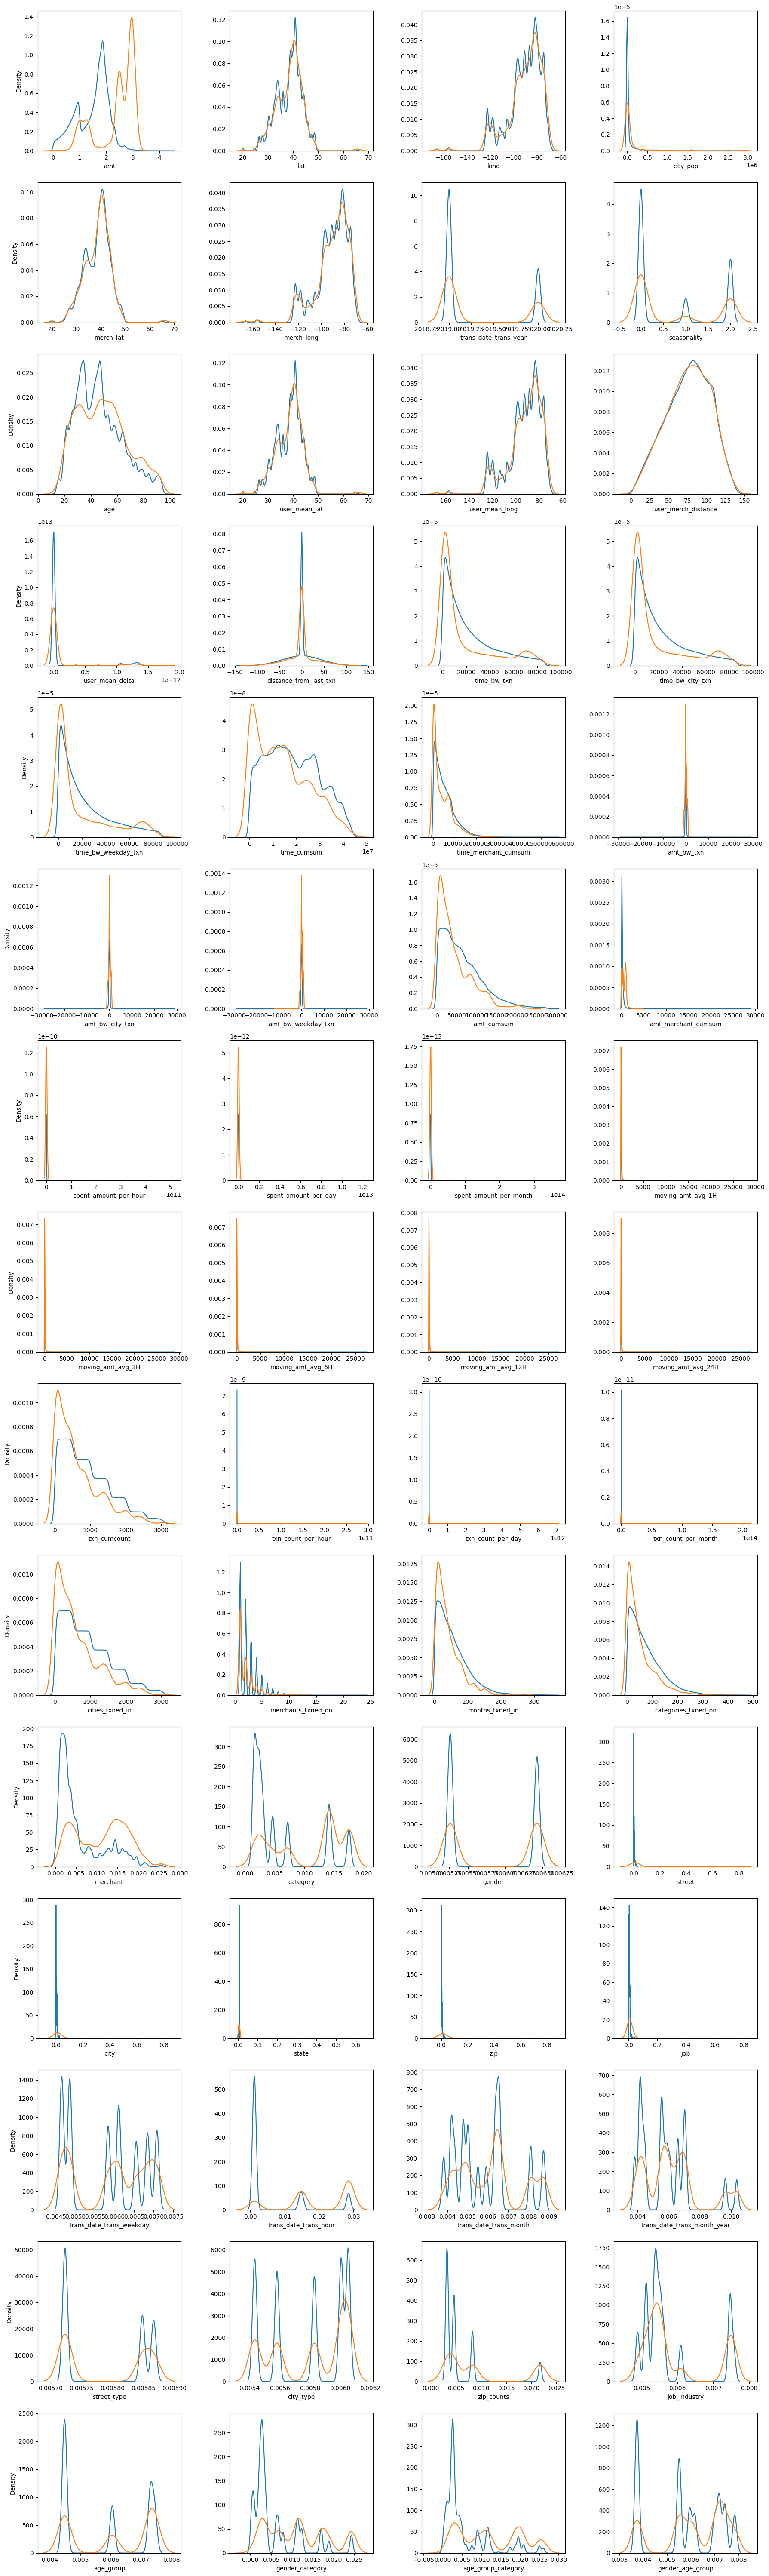

In [121]:
data_val_0, data_val_1 = train_df[train_df['is_fraud'] == 0].drop(columns=['trans_num', 'cc_num', 'is_fraud']), train_df[train_df['is_fraud'] == 1].drop(columns=['trans_num', 'cc_num', 'is_fraud'])

cols, ncols = list(train_df[train_df['is_fraud'] == 0].drop(columns=['trans_num', 'cc_num', 'is_fraud']).columns), 4
nrows = math.ceil(len(cols) / ncols)
fig, ax = plt.subplots(nrows, ncols, figsize = (4.5 * ncols, 4 * nrows))
for i in range(len(cols)):
    sns.kdeplot(data_val_0[cols[i]], ax = ax[i // ncols, i % ncols])
    sns.kdeplot(data_val_1[cols[i]], ax = ax[i // ncols, i % ncols])
    if i % ncols != 0:
        ax[i // ncols, i % ncols].set_ylabel(" ")
plt.tight_layout()
plt.show()

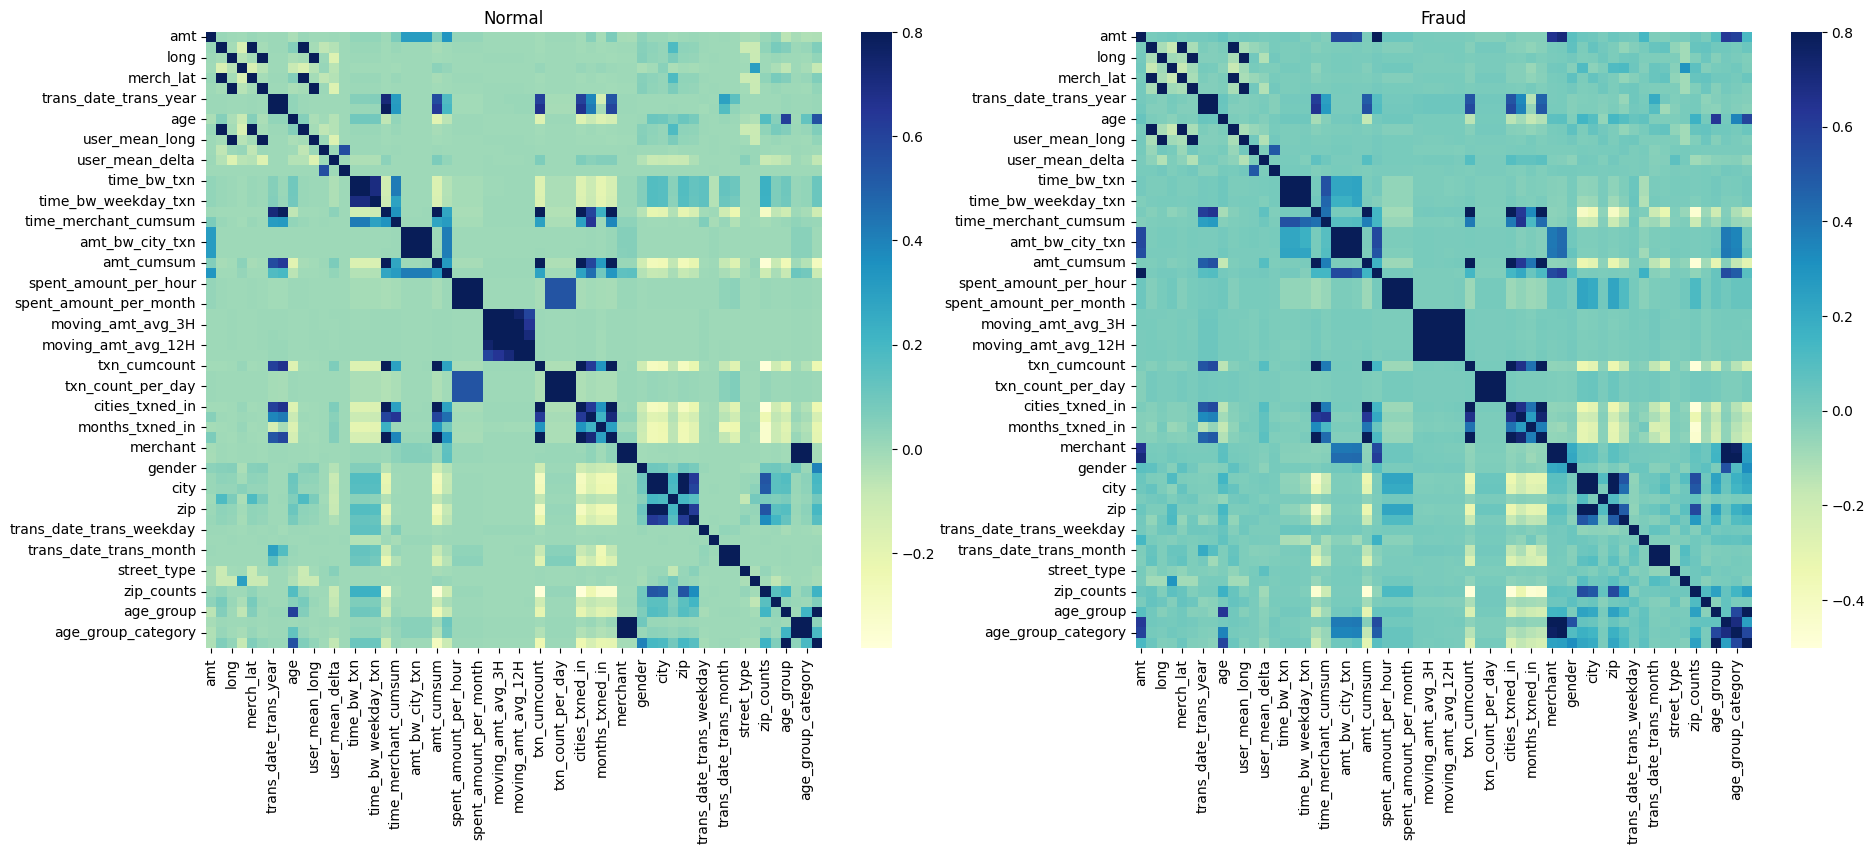

In [122]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.heatmap(data_val_0.corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Normal')
sns.heatmap(data_val_1.corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Fraud')
plt.show()

### Modelling - Supervised

In [124]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

def plot_precision_recall():
    plt.step(recall_score, precision_score, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall_score, precision_score, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall_score, precision_score, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

def plot_feature_importance(model, predictors):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (12,12))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()


In [125]:
X_train = train_df.drop(['is_fraud', 'cc_num', 'trans_num', 'is_fraud'], axis=1)
y_train = train_df.is_fraud

X_valid = test_df.drop(['is_fraud', 'cc_num', 'trans_num', 'is_fraud'], axis=1)
y_valid = test_df.is_fraud

In [138]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1296675, 60), (555719, 60), (1296675,), (555719,))

In [143]:
### Test set Results

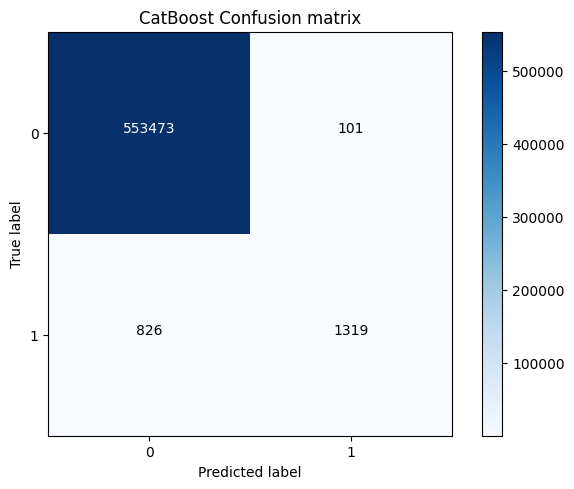

Precision =     0.929
Recall    =     0.615
F1_score  =     0.740
ROC AUC Score: 0.8073679820765125


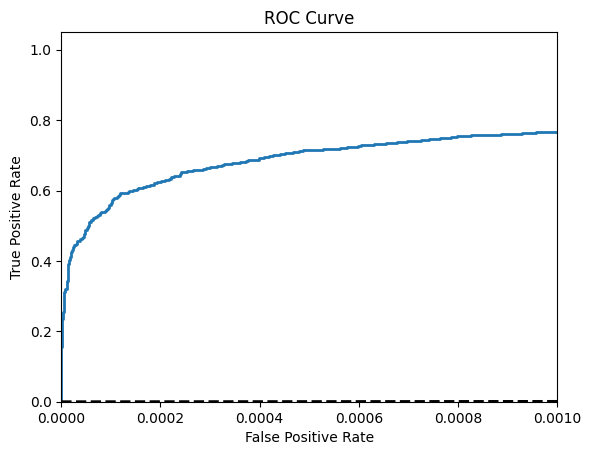

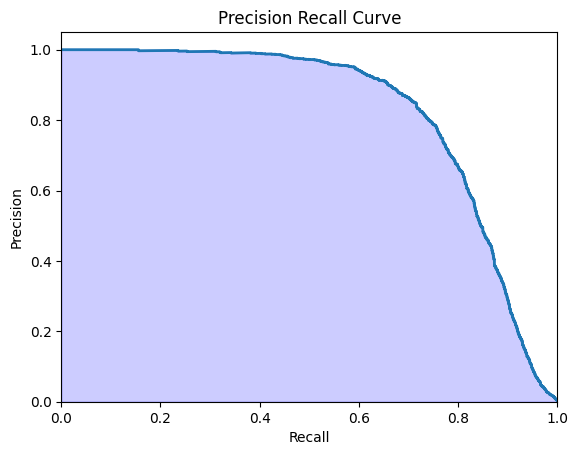

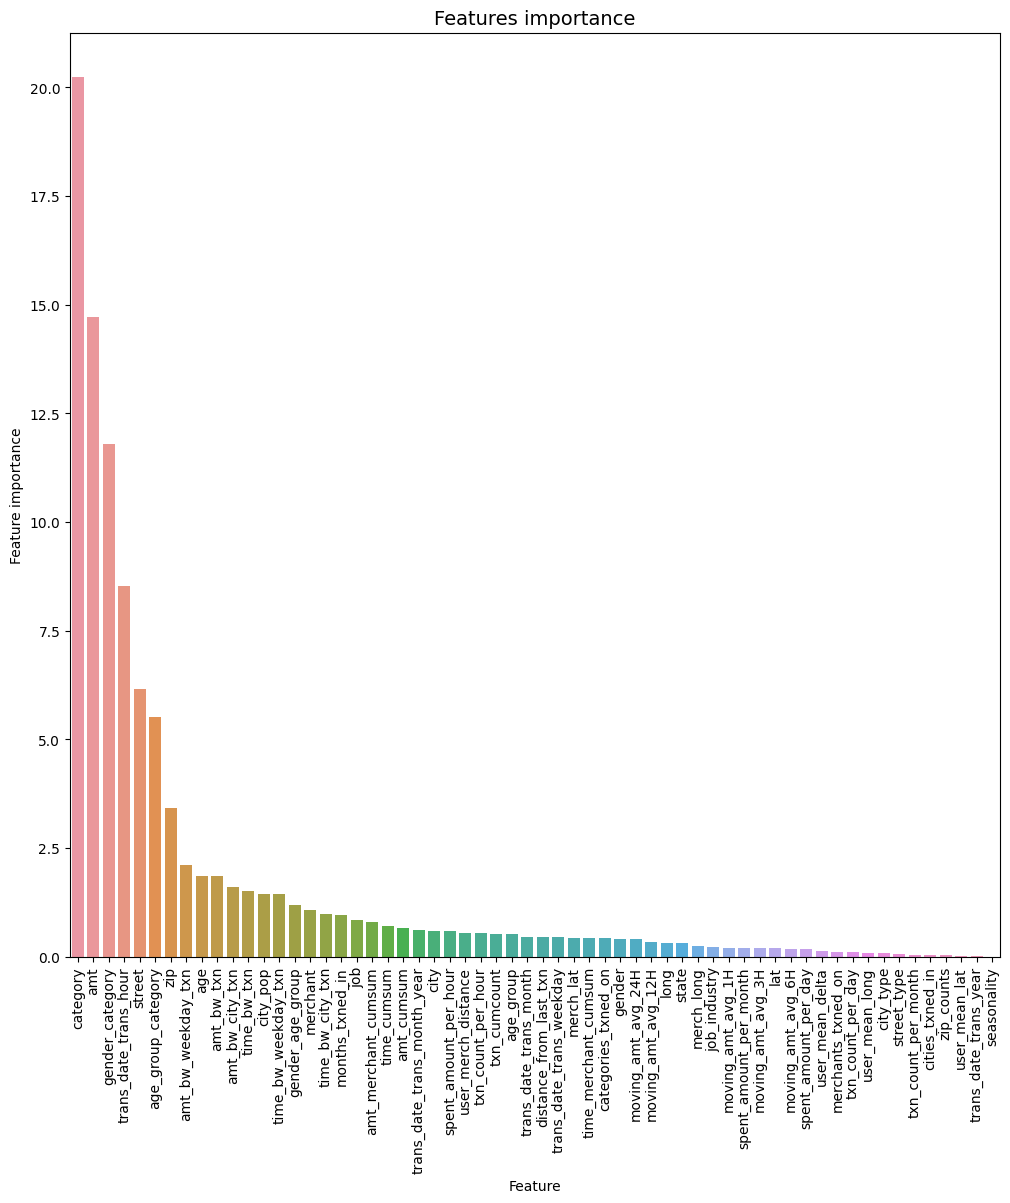

In [142]:
catboost_clf = CatBoostClassifier(random_state = 42, logging_level='Silent')

catboost_clf.fit(X_train, y_train)
y_pred = catboost_clf.predict(X_valid)
y_score = catboost_clf.predict_proba(X_valid)[:,1]

cm = confusion_matrix(y_valid, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm,
                      classes = class_names,
                      title = 'CatBoost Confusion matrix')
plt.show()
show_metrics()
print('ROC AUC Score:',metrics.roc_auc_score(y_valid, y_pred))
fpr, tpr, t = roc_curve(y_valid, y_score)
plot_roc()
# Precision-recall curve
precision_score, recall_score, thresholds = precision_recall_curve(y_valid, y_score)
plot_precision_recall()
plot_feature_importance(catboost_clf, catboost_clf.feature_names_)